##### Copyright 2018 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Text classification with an RNN

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/text/tutorials/text_classification_rnn"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/text/blob/master/docs/tutorials/text_classification_rnn.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/text/blob/master/docs/tutorials/text_classification_rnn.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/text/docs/tutorials/text_classification_rnn.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This text classification tutorial trains a [recurrent neural network](https://developers.google.com/machine-learning/glossary/#recurrent_neural_network) on the [IMDB large movie review dataset](http://ai.stanford.edu/~amaas/data/sentiment/) for sentiment analysis.

## Setup

In [4]:
import numpy as np

import tensorflow_datasets as tfds
import tensorflow as tf

#tfds.disable_progress_bar()#sirve para desactivar la barra de progreso de tensorflow

Import `matplotlib` and create a helper function to plot graphs:

In [5]:
import matplotlib.pyplot as plt


def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

## Setup input pipeline


The IMDB large movie review dataset is a *binary classification* dataset—all the reviews have either a *positive* or *negative* sentiment.

Download the dataset using [TFDS](https://www.tensorflow.org/datasets). See the [loading text tutorial](https://www.tensorflow.org/tutorials/load_data/text) for details on how to load this sort of data manually.


In [6]:
dataset, info = tfds.load('imdb_reviews', with_info=True,
                          as_supervised=True)#with_info=True para obtener información del dataset, as_supervised=True para obtener los datos en tuplas
train_dataset, test_dataset = dataset['train'], dataset['test']

train_dataset.element_spec#element_spec nos dice que tipo de datos tenemos en el dataset

Dataset imdb_reviews downloaded and prepared to C:\Users\victo\tensorflow_datasets\imdb_reviews\plain_text\1.0.0. Subsequent calls will reuse this data.


(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

Initially this returns a dataset of (text, label pairs):

In [9]:
len(train_dataset), len(test_dataset)

(25000, 25000)

In [8]:
for example, label in train_dataset.take(2):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
label:  0
text:  b'I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. However on this occasion I fell asleep because the film was rubbish. 

Next shuffle the data for training and create batches of these `(text, label)` pairs:

In [10]:
BUFFER_SIZE = 25000#tamaño del buffer
BATCH_SIZE = 64

In [11]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [13]:
for example, label in train_dataset.take(10):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])

texts:  [b"Knowing what to expect (on the whole) from a Denzel Washington performance - quality, integrity, gravitas, wry humour - will prepare you for what to expect from his directorial debut. Much like Robert De Niro's A Bronx Tale, Antwone Fisher delivers the moving drama of the life of a young man and the effects of key figures in his life. Much as in A Bronx Tale De Niro played one of these key figures to the lead character (himself a character was born to play but was too old too) Washington takes a similar role in this as the fatherly councellor to the titular character - a character that seems like he should be played by a Washington from 20 years ago. Be thankful Washington is too old to play Antwone because if he had we would firstly be deprived of the wonderfully measured and intelligently nuanced performance he gives as the Navy councellor. However more importantly we wouldn't get to see the superb, we can only hope star making, turn from Derek Luke in the title role. Inev

## Create the text encoder

The raw text loaded by `tfds` needs to be processed before it can be used in a model. The simplest way to process text for training is using the `TextVectorization` layer. This layer has many capabilities, but this tutorial sticks to the default behavior.

Create the layer, and pass the dataset's text to the layer's `.adapt` method:

In [14]:
VOCAB_SIZE = 10000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))#train_dataset.map(lambda text, label: text) para obtener solo los textos

The `.adapt` method sets the layer's vocabulary. Here are the first 20 tokens. After the padding and unknown tokens they're sorted by frequency: 

In [19]:
vocab = np.array(encoder.get_vocabulary())
print(len(encoder.get_vocabulary()))
vocab[:20]

10000


array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U17')

Once the vocabulary is set, the layer can encode text into indices. The tensors of indices are 0-padded to the longest sequence in the batch (unless you set a fixed `output_sequence_length`):

In [16]:
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[  2, 240, 238, ...,   0,   0,   0],
       [ 11, 206,   4, ...,   0,   0,   0],
       [ 11,   1,   1, ...,   0,   0,   0]], dtype=int64)

With the default settings, the process is not completely reversible. There are three main reasons for that:

1. The default value for `preprocessing.TextVectorization`'s `standardize` argument is `"lower_and_strip_punctuation"`.
2. The limited vocabulary size and lack of character-based fallback results in some unknown tokens.

In [17]:
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b"The worst kind of film. Basically, the US Declaration of Independence was replaced with a plasma screen and this fooled the museum's security for several days. Eh?<br /><br />The plasma screen that would theoretically run for less than 2 seconds off that watch battery, assuming it had a low enough internal resistance to deliver the required current, which it wouldn't.<br /><br />It would be possible with a dozen large car batteries and an inverter, but that system wouldn't fit into the case. Sorry to be anal, but this isn't even close to being plausible. The rest of the film wasn't a great deal better and I'm left wondering why the budget couldn't have been donated to charity or me."
Round-trip:  the worst kind of film basically the us [UNK] of independence was replaced with a [UNK] screen and this fooled the [UNK] security for several days [UNK] br the [UNK] screen that would [UNK] run for less than 2 seconds off that watch [UNK] assuming it had a low enough internal resi

## Create the model

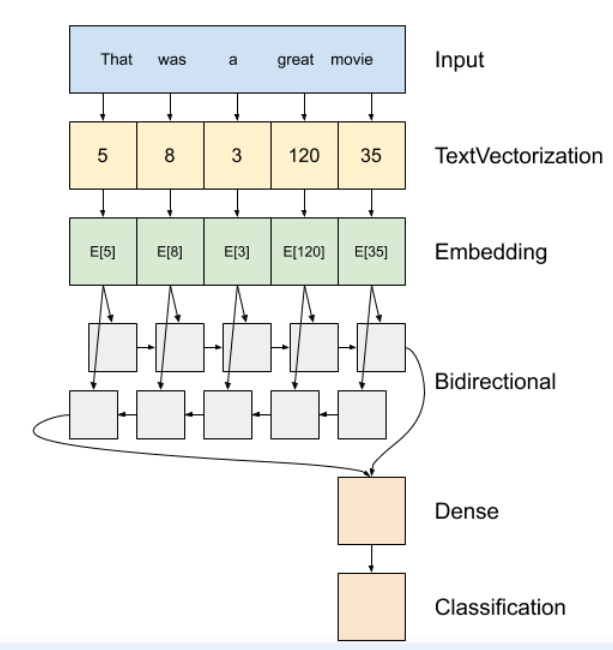

Above is a diagram of the model. 

1. This model can be build as a `tf.keras.Sequential`.

2. The first layer is the `encoder`, which converts the text to a sequence of token indices.

3. After the encoder is an embedding layer. An embedding layer stores one vector per word. When called, it converts the sequences of word indices to sequences of vectors. These vectors are trainable. After training (on enough data), words with similar meanings often have similar vectors.

  This index-lookup is much more efficient than the equivalent operation of passing a one-hot encoded vector through a `tf.keras.layers.Dense` layer.

4. A recurrent neural network (RNN) processes sequence input by iterating through the elements. RNNs pass the outputs from one timestep to their input on the next timestep.

  The `tf.keras.layers.Bidirectional` wrapper can also be used with an RNN layer. This propagates the input forward and backwards through the RNN layer and then concatenates the final output. 

  * The main advantage of a bidirectional RNN is that the signal from the beginning of the input doesn't need to be processed all the way through every timestep to affect the output.  

  * The main disadvantage of a bidirectional RNN is that you can't efficiently stream predictions as words are being added to the end.

5. After the RNN has converted the sequence to a single vector the two `layers.Dense` do some final processing, and convert from this vector representation to a single logit as the classification output. 


The code to implement this is below:

In [33]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

Please note that Keras sequential model is used here since all the layers in the model only have single input and produce single output. In case you want to use stateful RNN layer, you might want to build your model with Keras functional API or model subclassing so that you can retrieve and reuse the RNN layer states. Please check [Keras RNN guide](https://www.tensorflow.org/guide/keras/rnn#rnn_state_reuse) for more details.

The embedding layer [uses masking](https://www.tensorflow.org/guide/keras/masking_and_padding) to handle the varying sequence-lengths. All the layers after the `Embedding` support masking:

In [36]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


To confirm that this works as expected, evaluate a sentence twice. First, alone so there's no padding to mask:

In [37]:
# predict on a sample text without padding.

sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

1/1 [==============================] - 3s 3s/step
[-0.00786536]


Now, evaluate it again in a batch with a longer sentence. The result should be identical:

In [38]:
# predict on a sample text with padding

padding = "the " * 2000
predictions = model.predict(np.array([sample_text, padding]))
print(predictions[0])

1/1 [==============================] - 0s 258ms/step
[-0.00786925]


Compile the Keras model to configure the training process:

In [39]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

## Train the model

In [40]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10


391/391 [==============================] - 67s 154ms/step - loss: 0.5949 - accuracy: 0.6064 - val_loss: 0.4023 - val_accuracy: 0.8172
Epoch 2/10
391/391 [==============================] - 58s 149ms/step - loss: 0.3190 - accuracy: 0.8665 - val_loss: 0.3194 - val_accuracy: 0.8755
Epoch 3/10
391/391 [==============================] - 59s 151ms/step - loss: 0.2373 - accuracy: 0.9058 - val_loss: 0.2973 - val_accuracy: 0.8802
Epoch 4/10
391/391 [==============================] - 59s 151ms/step - loss: 0.1899 - accuracy: 0.9309 - val_loss: 0.3047 - val_accuracy: 0.8823
Epoch 5/10
391/391 [==============================] - 60s 152ms/step - loss: 0.1786 - accuracy: 0.9373 - val_loss: 0.3134 - val_accuracy: 0.8760
Epoch 6/10
391/391 [==============================] - 60s 153ms/step - loss: 0.1415 - accuracy: 0.9524 - val_loss: 0.3721 - val_accuracy: 0.8786
Epoch 7/10
391/391 [==============================] - 60s 152ms/step - loss: 0.1204 - accuracy: 0.9600 - val_loss: 0.4048 - val_accuracy: 0.8

In [41]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 30s 78ms/step - loss: 0.4474 - accuracy: 0.8585
Test Loss: 0.44744500517845154
Test Accuracy: 0.8584799766540527


(0.0, 0.6203840274363757)

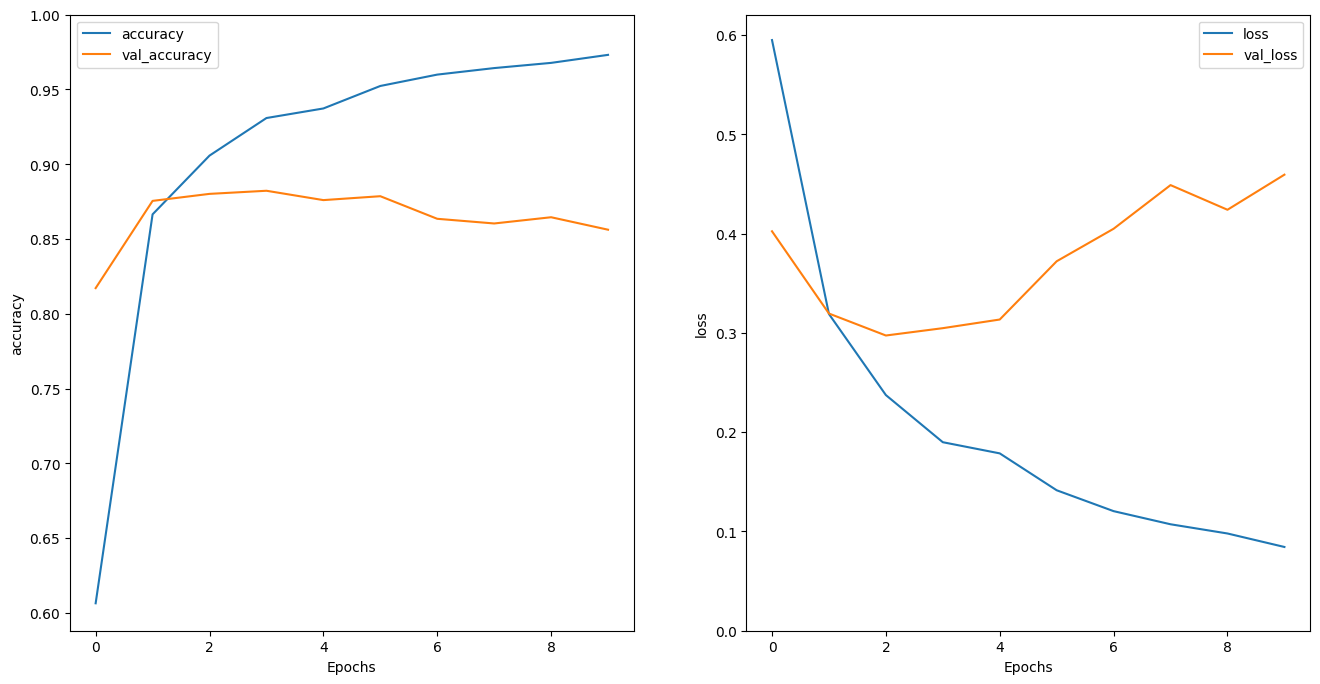

In [42]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

Run a prediction on a new sentence:

If the prediction is >= 0.0, it is positive else it is negative.

In [43]:
sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))

1/1 [==============================] - 2s 2s/step


In [44]:
print(predictions)#es positivo

[[2.078032]]


## Stack two or more LSTM layers

Keras recurrent layers have two available modes that are controlled by the `return_sequences` constructor argument:

* If `False` it returns only the last output for each input sequence (a 2D tensor of shape (batch_size, output_features)). This is the default, used in the previous model.

* If `True` the full sequences of successive outputs for each timestep is returned (a 3D tensor of shape `(batch_size, timesteps, output_features)`).

Here is what the flow of information looks like with `return_sequences=True`:

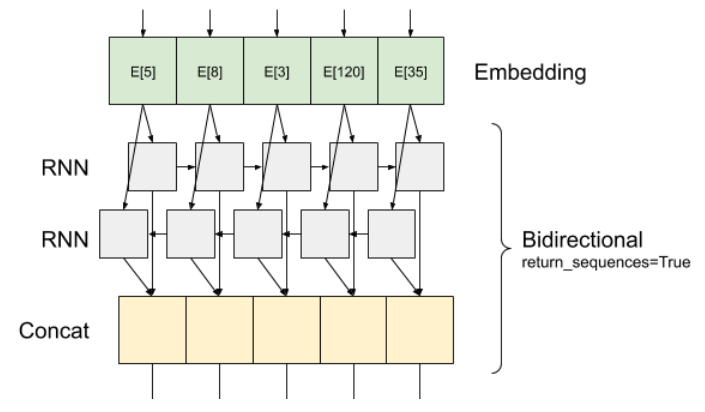

The interesting thing about using an `RNN` with `return_sequences=True` is that the output still has 3-axes, like the input, so it can be passed to another RNN layer, like this:

In [45]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

In [46]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [47]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 130s 300ms/step - loss: 0.5910 - accuracy: 0.6229 - val_loss: 0.4080 - val_accuracy: 0.8375
Epoch 2/10
391/391 [==============================] - 114s 291ms/step - loss: 0.2998 - accuracy: 0.8798 - val_loss: 0.3192 - val_accuracy: 0.8818
Epoch 3/10
391/391 [==============================] - 116s 296ms/step - loss: 0.2216 - accuracy: 0.9173 - val_loss: 0.3010 - val_accuracy: 0.8719
Epoch 4/10
391/391 [==============================] - 111s 284ms/step - loss: 0.1750 - accuracy: 0.9380 - val_loss: 0.3238 - val_accuracy: 0.8776
Epoch 5/10
391/391 [==============================] - 111s 284ms/step - loss: 0.1410 - accuracy: 0.9519 - val_loss: 0.3474 - val_accuracy: 0.8745
Epoch 6/10
391/391 [==============================] - 112s 287ms/step - loss: 0.1197 - accuracy: 0.9613 - val_loss: 0.3950 - val_accuracy: 0.8661
Epoch 7/10
391/391 [==============================] - 112s 287ms/step - loss: 0.1014 - accuracy: 0.9679 - val_loss: 0.4026 -

In [48]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 56s 143ms/step - loss: 0.5582 - accuracy: 0.8631
Test Loss: 0.5581690669059753
Test Accuracy: 0.8631200194358826


In [50]:
# predict on a sample text without padding.

sample_text = ('The movie was not good. The animation and the graphics '
               'were terrible. I would not recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions)

1/1 [==============================] - 4s 4s/step
[[-2.1227927]]


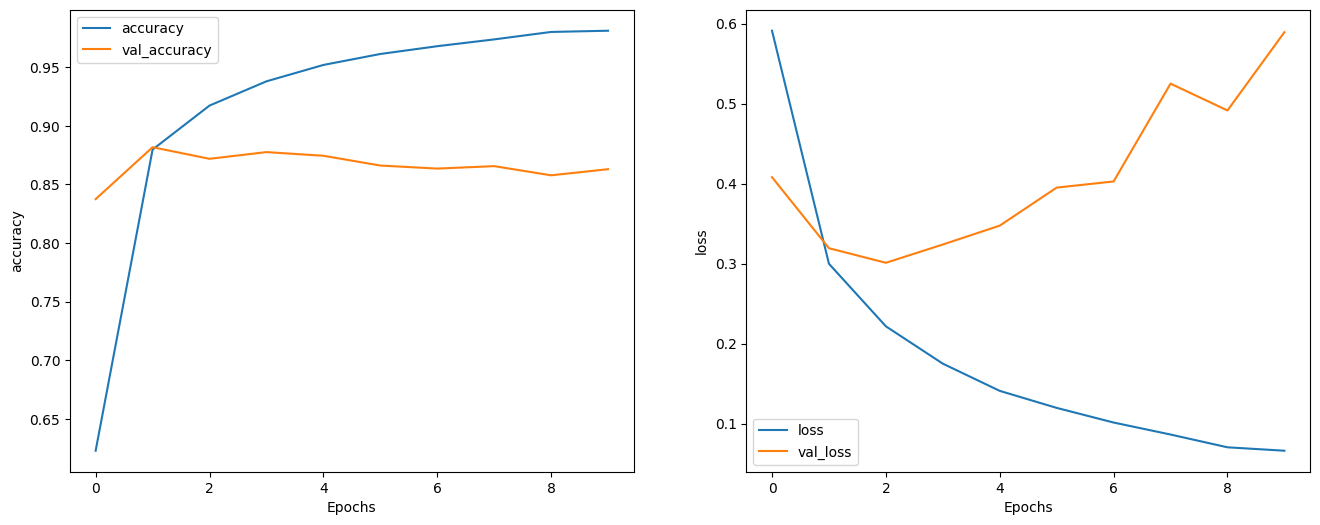

In [49]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')